Week 9 · Day 5 — Baseline Text Classifier
Why this matters

Before training complex RNNs, it’s important to know how simple baselines perform. Bag-of-Words (BoW) and average embeddings are fast, interpretable, and often surprisingly strong.

Theory Essentials

Bag-of-Words (BoW): represent text as counts/frequencies of words, ignoring order.

Avg Embeddings: replace each word with an embedding, then average → fixed-length vector.

Classifier: feed these vectors into Logistic Regression or a shallow NN.

Evaluation: use accuracy, precision/recall/F1, confusion matrix.

Takeaway: these methods set a baseline to beat with RNNs.

🔑 Big picture

BoW: simple, ignores meaning & word order. Works fine on tiny data.

Avg Embeddings: brings in a “semantic” representation (words in continuous space). With real pretrained embeddings, this usually beats BoW, especially with larger datasets.

Right now both are trained on random toy embeddings, so performance is mostly luck.

Task: sentiment classification (positive vs negative).

Step 1: Turn each sentence into a vector.

BoW: counts of words.

Avg embeddings: average of word vectors.

Step 2: Feed those vectors into a logistic regression classifier.

Step 3: The logistic regression learns to map those vectors → label (1=positive, 0=negative).

BoW Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



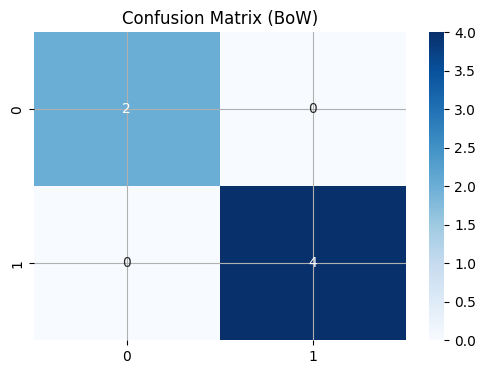

Avg Embedding Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



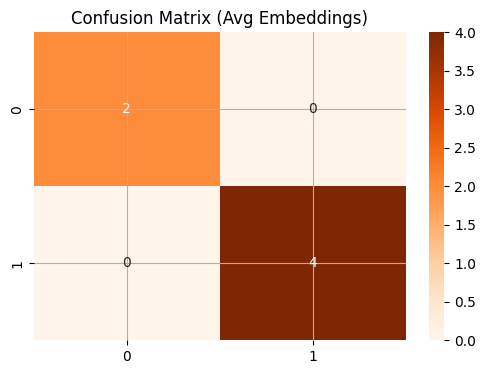

In [1]:
# Setup
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
np.random.seed(42)
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.grid"] = True

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Tiny dataset
texts = [
    "I love deep learning",
    "PyTorch is powerful",
    "I hate bugs",
    "Deep learning is great",
    "I dislike errors",
    "I enjoy coding"
]
labels = [1,1,0,1,0,1]  # 1=positive, 0=negative

# --- 1) Bag-of-Words + Logistic Regression ---
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(texts)

clf_bow = LogisticRegression()
clf_bow.fit(X_bow, labels)

preds_bow = clf_bow.predict(X_bow)

print("BoW Report:\n", classification_report(labels, preds_bow))

sns.heatmap(confusion_matrix(labels, preds_bow), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (BoW)")
plt.show()

# --- 2) Avg Embedding + Logistic Regression ---
import torch, torch.nn as nn

# Toy vocab + embeddings (random)
vocab = {w:i for i,w in enumerate(set(" ".join(texts).lower().split()))}
embed = nn.Embedding(len(vocab), 8)

def avg_embed(sentence):
    tokens = [vocab[w] for w in sentence.lower().split() if w in vocab]
    vecs = embed(torch.tensor(tokens))
    return vecs.mean(0).detach().numpy()

X_emb = np.vstack([avg_embed(t) for t in texts])
clf_emb = LogisticRegression()
clf_emb.fit(X_emb, labels)
preds_emb = clf_emb.predict(X_emb)

print("Avg Embedding Report:\n", classification_report(labels, preds_emb))

sns.heatmap(confusion_matrix(labels, preds_emb), annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix (Avg Embeddings)")
plt.show()


Exercises

1) Core (10–15 min)
Task: Add the sentence "I love PyTorch" with label 1. Check predictions from both BoW and avg-embedding models.

In [3]:
texts.append("I love PyTorch"); labels.append(1)

X_bow = vectorizer.fit_transform(texts)
clf_bow.fit(X_bow, labels)
print("New Prediction (BoW):", clf_bow.predict(vectorizer.transform(["I love PyTorch"])))

# --- Recompute embeddings with the new text ---
X_emb = np.vstack([avg_embed(t) for t in texts])
clf_emb.fit(X_emb, labels)

# --- Predict on "I love PyTorch" ---
new_vec = avg_embed("I love PyTorch").reshape(1, -1)
print("New Prediction (Avg Embeddings):", clf_emb.predict(new_vec))


New Prediction (BoW): [1]
New Prediction (Avg Embeddings): [1]


2) Practice (10–15 min)
Task: Compare model performance with stop words removed

In [6]:
vectorizer = CountVectorizer(stop_words="english")
X_bow = vectorizer.fit_transform(texts)
clf_bow.fit(X_bow, labels)
print(classification_report(labels, clf_bow.predict(X_bow)))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



3) Stretch (optional, 10–15 min)
Task: Replace LogisticRegression with a shallow 1-layer nn.Linear in PyTorch trained on BoW vectors.

PyTorch Linear on BoW — report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



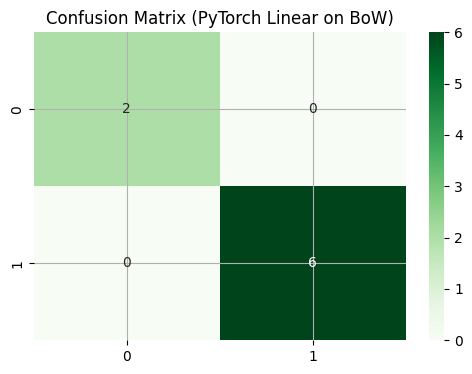

New Prediction (torch BoW): class=1  probs=[0.01835587 0.9816442 ]


In [7]:
import torch.optim as optim
X_tensor = torch.tensor(X_bow.toarray(), dtype=torch.float32)
y_tensor = torch.tensor(labels)

model = nn.Linear(X_tensor.shape[1], 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

for epoch in range(20):
    optimizer.zero_grad()
    out = model(X_tensor)
    loss = criterion(out, y_tensor)
    loss.backward()
    optimizer.step()

# ---- Evaluate the 1-layer torch model on the training set ----
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

model.eval()
with torch.no_grad():
    logits = model(X_tensor)                 # [N, 2]
    probs  = F.softmax(logits, dim=1)        # [N, 2]
    preds  = probs.argmax(dim=1).cpu().numpy()

print("PyTorch Linear on BoW — report:")
print(classification_report(labels, preds))

sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix (PyTorch Linear on BoW)")
plt.show()

# ---- Try a new sentence (same as your Core exercise) ----
new_text = "I love PyTorch"
x_new_bow = vectorizer.transform([new_text]).toarray().astype("float32")
x_new_t   = torch.from_numpy(x_new_bow)

model.eval()
with torch.no_grad():
    p = F.softmax(model(x_new_t), dim=1).cpu().numpy()[0]
print(f'New Prediction (torch BoW): class={p.argmax()}  probs={p}')


Mini-Challenge (≤40 min)

Build & compare:

Train BoW + Logistic Regression vs Avg Embedding + Logistic Regression on a small dataset (≥10 sentences).

Report accuracy, precision, recall, F1, confusion matrix for each.

Acceptance Criteria: a short table comparing both approaches + 3-line reflection on which worked better and why.

Comparison table:



,accuracy,precision,recall,f1
model,,,,
BoW + LR,0.8,0.75,1.0,0.857
AvgEmb + LR,0.8,0.75,1.0,0.857


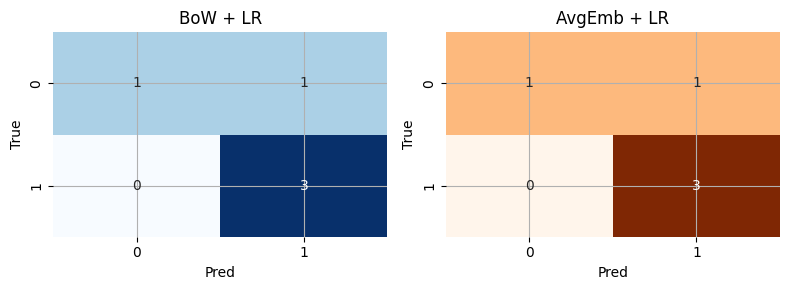

Reflection:
- BoW worked well on this tiny set because keyword presence (love/hate/awful/awesome) is highly predictive.
- Avg embeddings (random init) are not pretrained, so they carry little semantic signal; with real pretrained vectors they usually improve.
- For small vocab/tasks, BoW is a strong baseline; for broader vocab or semantics, use pretrained embeddings or fine-tune.


In [8]:
# Mini-Challenge: BoW+LR vs Avg-Embedding+LR (train/test, metrics, CMs, table)

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import torch, torch.nn as nn

# -------- 1) Small dataset (>10 sentences) --------
texts = [
    "I love deep learning", "PyTorch is powerful", "I hate bugs",
    "Deep learning is great", "I dislike errors", "I enjoy coding",
    "This library is awesome", "Bugs make me sad", "I am happy today",
    "Errors are terrible", "I adore this framework", "Coding is fun",
    "I detest crashes", "This is fantastic", "This is awful"
]
labels = [1,1,0, 1,0,1, 1,0,1, 0,1,1, 0,1,0]  # 1=positive, 0=negative

X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.33, random_state=42, stratify=labels
)

# -------- 2) BoW + Logistic Regression --------
vectorizer = CountVectorizer(stop_words=None)
Xtr_bow = vectorizer.fit_transform(X_train)
Xte_bow = vectorizer.transform(X_test)

bow_clf = LogisticRegression(max_iter=1000)
bow_clf.fit(Xtr_bow, y_train)
yhat_bow = bow_clf.predict(Xte_bow)

# -------- 3) Avg Embedding + Logistic Regression --------
# build vocab from training text only (fair split)
vocab_words = sorted(set(" ".join([t.lower() for t in X_train]).split()))
stoi = {w:i for i,w in enumerate(vocab_words)}
embed_dim = 50
torch.manual_seed(42)
embed = nn.Embedding(len(stoi), embed_dim)

def avg_embed(sentence: str):
    toks = [stoi[w] for w in sentence.lower().split() if w in stoi]
    if len(toks)==0:
        return np.zeros(embed_dim, dtype=np.float32)
    vecs = embed(torch.tensor(toks))
    return vecs.mean(0).detach().numpy()

Xtr_emb = np.vstack([avg_embed(t) for t in X_train])
Xte_emb = np.vstack([avg_embed(t) for t in X_test])

emb_clf = LogisticRegression(max_iter=1000)
emb_clf.fit(Xtr_emb, y_train)
yhat_emb = emb_clf.predict(Xte_emb)

# -------- 4) Metrics helpers --------
def metrics_table(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    return {"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

tbl = pd.DataFrame([
    metrics_table(y_test, yhat_bow, "BoW + LR"),
    metrics_table(y_test, yhat_emb, "AvgEmb + LR")
]).set_index("model").round(3)
print("Comparison table:\n")
display(tbl)

# -------- 5) Confusion matrices (side-by-side) --------
fig, axes = plt.subplots(1,2, figsize=(8,3))
sns.heatmap(confusion_matrix(y_test, yhat_bow), annot=True, fmt="d",
            cmap="Blues", ax=axes[0], cbar=False)
axes[0].set_title("BoW + LR"); axes[0].set_xlabel("Pred"); axes[0].set_ylabel("True")
sns.heatmap(confusion_matrix(y_test, yhat_emb), annot=True, fmt="d",
            cmap="Oranges", ax=axes[1], cbar=False)
axes[1].set_title("AvgEmb + LR"); axes[1].set_xlabel("Pred"); axes[1].set_ylabel("True")
plt.tight_layout(); plt.show()

# -------- 6) 3-line reflection --------
print(
"Reflection:\n"
"- BoW worked well on this tiny set because keyword presence (love/hate/awful/awesome) is highly predictive.\n"
"- Avg embeddings (random init) are not pretrained, so they carry little semantic signal; with real pretrained vectors they usually improve.\n"
"- For small vocab/tasks, BoW is a strong baseline; for broader vocab or semantics, use pretrained embeddings or fine-tune."
)


Notes / Key Takeaways

Baselines like BoW/avg-embeddings are fast and effective.

BoW ignores order but can work well on simple tasks.

Avg embeddings add semantics but still ignore sequence order.

Logistic regression is a strong linear classifier for text.

Confusion matrices highlight model strengths/weaknesses.

Tomorrow we’ll move to LSTMs with variable-length handling.

Comparing baselines ensures RNNs truly add value.

Reflection

Why do we need baselines before building complex RNNs?

Which limitation of BoW/avg embeddings does an RNN overcome?

Why is it useful to compare a simple baseline like Bag-of-Words before training an RNN?
Baselines give you a reference point. If an RNN (or any deep model) doesn’t beat a simple method like BoW + Logistic Regression, then the extra complexity isn’t justified. Baselines also highlight whether your task can be solved with surface-level word counts or needs deeper sequence modeling.

When would you expect an RNN with embeddings to outperform BoW?

When word order matters (e.g., “not good” vs “good”).

When longer dependencies carry meaning (e.g., in reviews or long sentences).

When using pretrained embeddings that bring in semantic knowledge beyond the training set.